# Working with the YOLO Model for Header Detection

This notebook provides a brief description of the procedure for loading a YOLO model trained for the detection of headers in government documents. For performance reasons, we will use the `onnx` version of the model, which has several speed improvements over the original. This does require us to do some additional pre- and postprocessing on the images so that the model works with images of different sizes, and that the output is equal to that of the original model.

Additionally we provide some more code to merge bounding boxes into larger contours, to reduce the amount of noise in terms of false positive bounding boxes.

In [2]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from glob import glob
import onnxruntime as ort
from typing import List, Tuple
import matplotlib.pyplot as plt
from pdf2image import convert_from_path


## Preparing input data 

In order to be able to use the model on PDF's, we have to perform a few tasks. We have to split the PDF into a list of images, and pre-process each of the images so that it corresponds to the input expected by the YOLO model. This mostly consists of padding the input image so that both the width and height are multiples of 32. (For the conversion to PNG we use `pdf2image` for the conversion from PDF to PNG, you might have to `pip install` this first.)

In [ ]:
#pip install pdf2image # This might require you to additionally instal poppler on your system


In [3]:
import cv2

def load_and_process_pdf(path_to_pdf_file: str) -> List[np.ndarray] :
    """
    This function takes as input the path to a PDF file, and returns a list of numpy 
    arrays representing the images, which are preprocessed for usage with a YOLO model
    """
    list_of_images = convert_from_path(path_to_pdf_file)

    # Run the pre-processing function on all images, and return the list
    return [np.array(image_array) for image_array in list_of_images]


Using this function, we can now convert an example pdf into a list of numpy arrays.

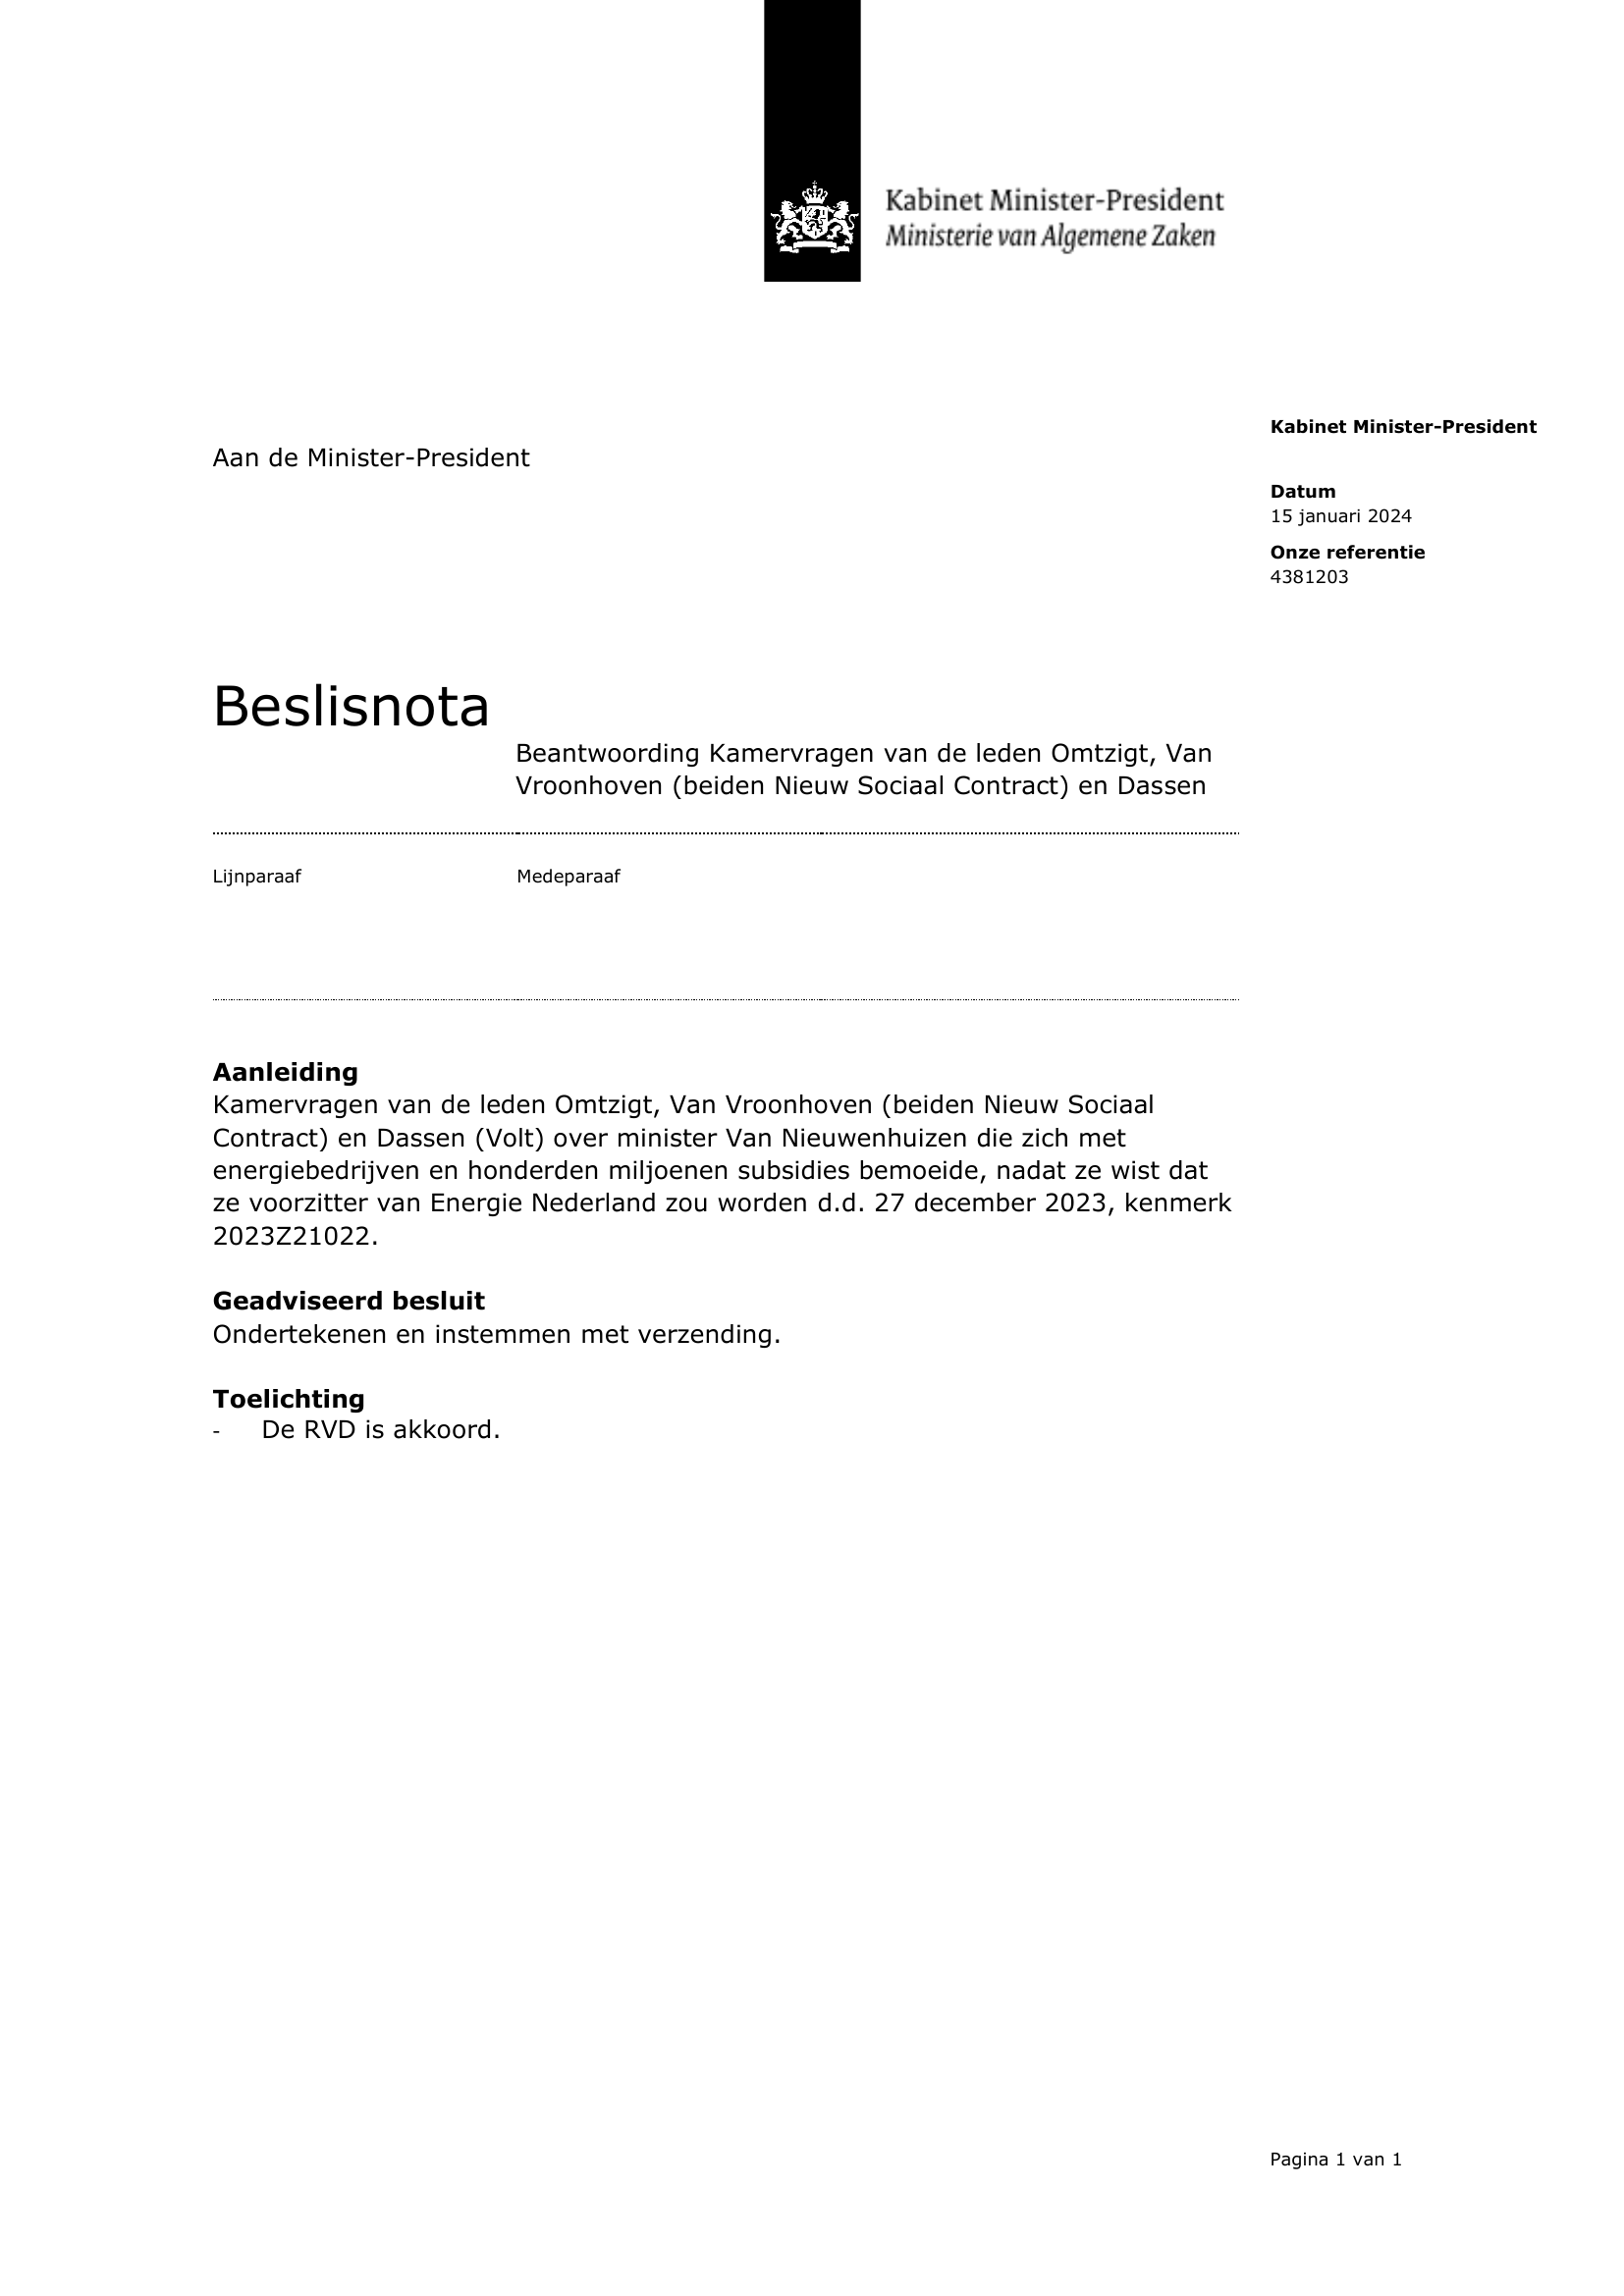

In [5]:
example_images = load_and_process_pdf('../BeslisnotaPDFs/nl.mnre1010.2e-b.2024.1.doc.1.pdf')
Image.fromarray(example_images[0])


This looks good, now the next step is to implement the padding function, and a scaling function to map bounding boxes back into the original image that did not have the padding.

In [6]:
def letterbox_padding(img: np.ndarray, new_shape=(640, 640), color=(114, 114, 114)):
    """
    Function that performs letterbox padding, the same padding used by the YOLO model during training.
    This type of padding adds extra pixels to the image so that it is the right size, while maintaining
    the original aspect ratio of the image.
    
    """
    # Get the current size of the image
    shape = img.shape[:2]

    # Get the ratio between the original shapes and the desired shapes
    ratio = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    # Get the size of the image that does not have to be padded
    new_unpad = (int(round(shape[1] * ratio)), int(round(shape[0] * ratio)))
    # Calculate padding
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]
    dw /= 2  # divide padding into two sides
    dh /= 2

    # Resize the image to the new image size, but without padding
    img_resized = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    # Add padding to the image
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right,
                                    cv2.BORDER_CONSTANT, value=color)

    return img_padded, ratio, (dw, dh)

def scale_boxes(boxes: np.ndarray, original_shape: Tuple[int], ratio: float, pad: Tuple[float]) -> np.ndarray:
    """
    Function that converts the output boxes (which were predicted on the padded image)
    back to the correct coordinates of the original image, without the padding.
    """

    # Remove the padding from the boxes
    boxes[:, [0, 2]] -= pad[0]  # x padding
    boxes[:, [1, 3]] -= pad[1]  # y padding\

    # Scale the boxes back to the correct ratio
    boxes[:, :4] /= ratio
    # Clip any out-of-bounds pixels to be within the original image limits
    boxes[:, :4] = boxes[:, :4].clip(0, [original_shape[1], original_shape[0],
                                         original_shape[1], original_shape[0]])
    
    return boxes


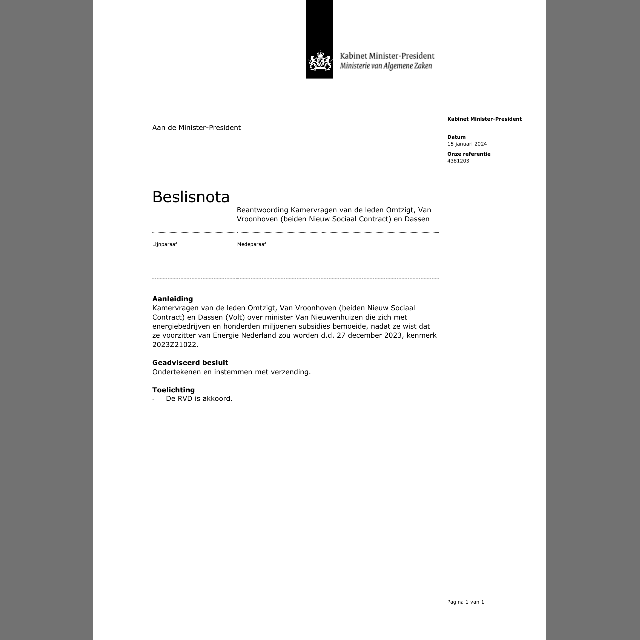

In [7]:
# small example of the padding, where gray boxes are added to the image to preserve the aspect ratio
padded_example_image, ratio, padding = letterbox_padding(example_images[0])
# for visualization of the padding, we temporarily 'undo' the last scaling and permuting steps
Image.fromarray(padded_example_image)


## Running the Model

With all the loading and pre-processing operations in place, we can now run the model on our processed image, and visualize the predicted bounding boxes. We will write a predict function that, given a padded image, will predict the bounding boxes. Later in the notebook, we will write another function that combines the pre-processing, prediction and post-processing steps into one.

In [8]:
# Load the model using the onnx runtime
session = ort.InferenceSession('trained_models/onnx/model.onnx', providers=['CPUExecutionProvider'])
# Get the correct names of the input and output variables from the model
input_name = session.get_inputs()[0].name
output_names = [o.name for o in session.get_outputs()]


In [9]:
def predict(image: np.ndarray) -> np.ndarray:
    """
    Function that, given a pre-processed (padded) image runs the YOLO model on that image
    and return the (uncorrected) bounding boxes. Note that this function does not return just 
    the boxes, but actually a N by 6 matrix, where the 5th and 6th rows are the confidence and bounding
    boxes class respectively. In our case the class is irrelevant, and will always be zero.
    """
    # After padding, we still have to scale the pixel values and permute the image axes
    image_input = image.astype(np.float32) / 255.0
    image_input = np.transpose(image_input, (2, 0, 1))[None]  # (1, 3, H, W)
    
    outputs = session.run(output_names, {input_name: image_input})
    
    raw_detections = outputs[0][0] # note that detections are in the (x1,y1, x2, y2) format for bounding boxes
    
    # We want to remove rows which are all zeros
    detections = raw_detections[~np.all(raw_detections == 0, axis=1)]
    
    return detections


In [10]:
# run the prediction model
model_predictions = predict(padded_example_image)
print(f"The model has predicted {model_predictions.shape[0]} boxes in the image")
# scale the boxes back to their original sizes for the unpadded image
model_predictions_scaled = scale_boxes(model_predictions, np.array(example_images[0].shape), ratio, padding)
model_predictions_scaled


The model has predicted 3 boxes in the image


array([[8.9632373e+02, 1.7630072e+02, 1.2665377e+03, 2.7906717e+02,
        7.6144218e-01, 0.0000000e+00],
       [1.2700006e+03, 4.0341052e+02, 1.5893800e+03, 6.1898322e+02,
        7.5668764e-01, 0.0000000e+00],
       [2.0279256e+02, 4.2765622e+02, 5.6406482e+02, 4.9319293e+02,
        4.6859697e-01, 0.0000000e+00]], dtype=float32)

## Post-Processing

The model predictions that we have now are not processed yet, meaning that they might contain overlapping boxes, and boxes with very low confidence. We write some post-processing code that filters this, and scales the boxes back from the padded images to the original image.

In [11]:
import numpy as np

def box_iou(box1: np.ndarray, box2: np.ndarray) -> float:
    """Compute IoU between box1 (N, 4) and box2 (M, 4)"""
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    inter_x1 = np.maximum(box1[:, None, 0], box2[:, 0])
    inter_y1 = np.maximum(box1[:, None, 1], box2[:, 1])
    inter_x2 = np.minimum(box1[:, None, 2], box2[:, 2])
    inter_y2 = np.minimum(box1[:, None, 3], box2[:, 3])

    inter_w = np.maximum(0, inter_x2 - inter_x1)
    inter_h = np.maximum(0, inter_y2 - inter_y1)
    inter_area = inter_w * inter_h

    union_area = area1[:, None] + area2 - inter_area
    return inter_area / (union_area + 1e-6)

def remove_overlapping_boxes(boxes: np.ndarray) -> np.ndarray:
    """
    Function that removes box overlap, by only keeping the boxes with the highest confidence
    """
    if len(boxes) == 0:
        return boxes

    boxes = boxes[np.argsort(-boxes[:, 4])]  # sort by confidence descending
    keep = []
    suppressed = np.zeros(len(boxes), dtype=bool)

    for i in range(len(boxes)):
        if suppressed[i]:
            continue
        keep.append(boxes[i])
        ious = box_iou(boxes[i:i+1, :4], boxes[i+1:, :4])[0]
        overlap_indices = np.where(ious > 0)[0] + i + 1
        suppressed[overlap_indices] = True

    return np.stack(keep) if keep else np.zeros((0, 6))


In [12]:
non_overlapping_boxes = remove_overlapping_boxes(model_predictions_scaled)
print(f"After filtering, we have {non_overlapping_boxes.shape[0]} boxes left")


After filtering, we have 3 boxes left


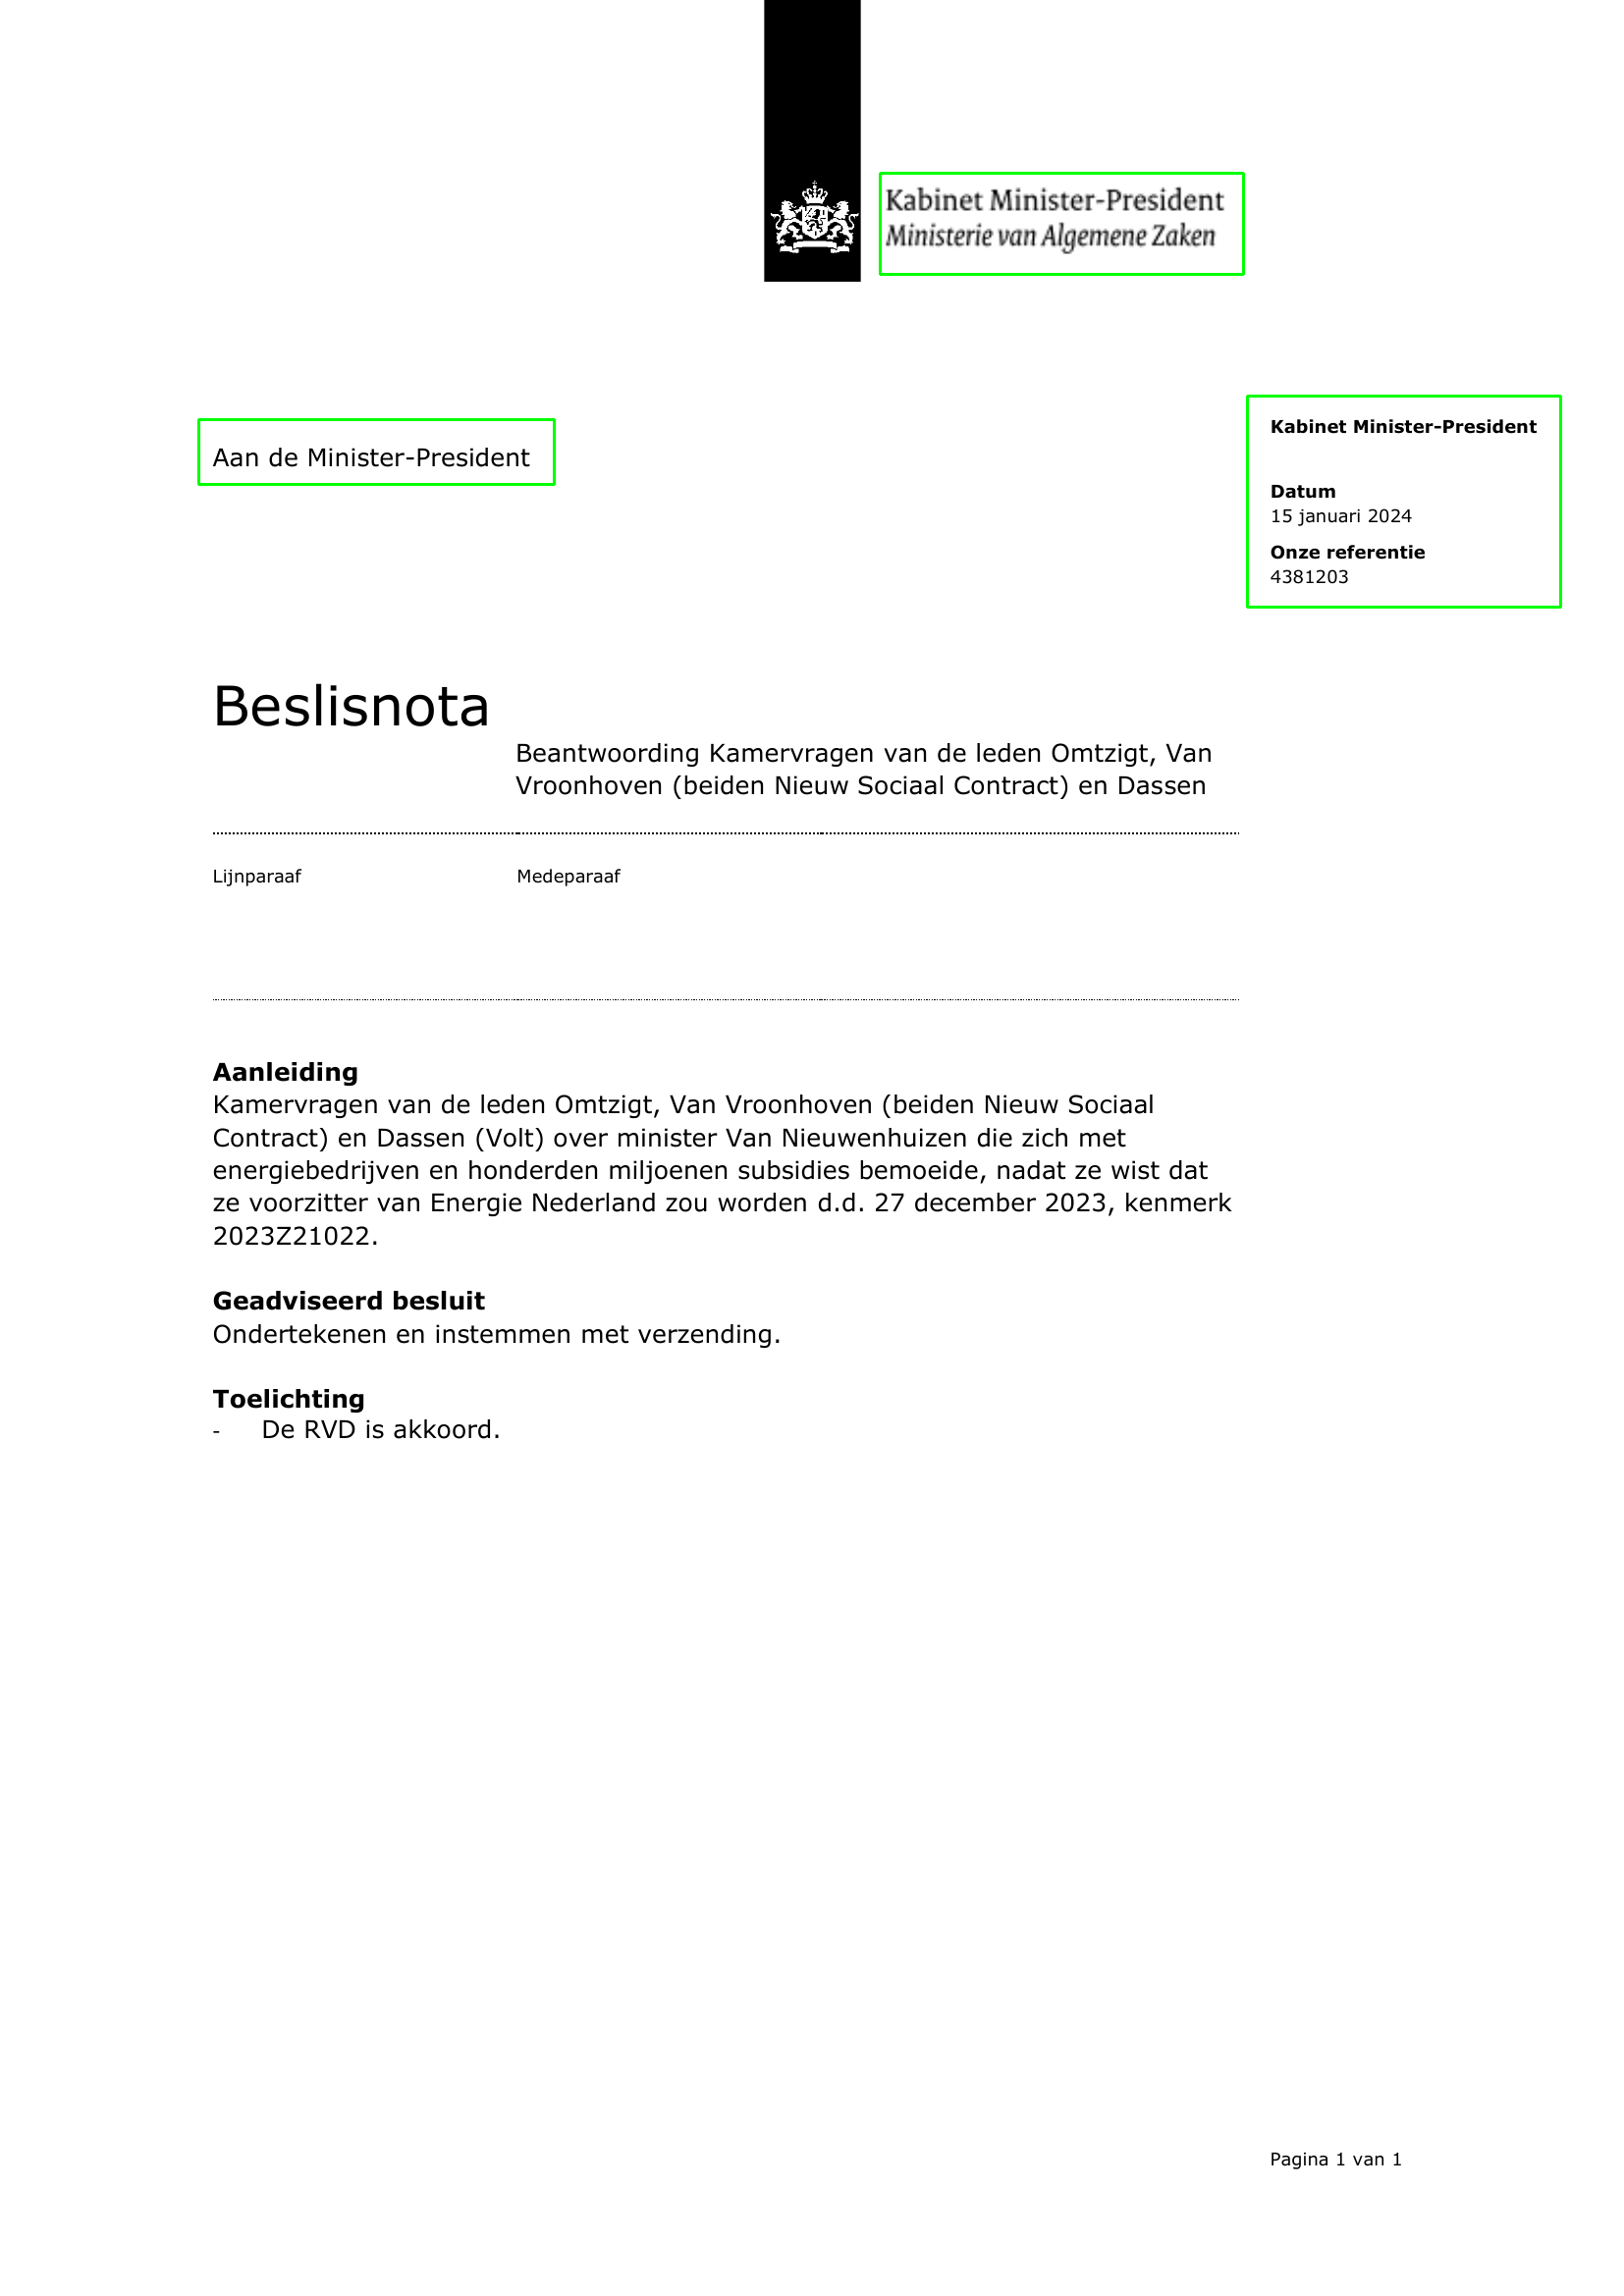

In [13]:
# Let's visualize the boxes
image = example_images[0].copy()
for *xyxy, conf, cls in non_overlapping_boxes:
    x1, y1, x2, y2 = map(int, xyxy)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

Image.fromarray(image)


## Combining all the Steps

Putting this all together, we will now write a complete function that, given an image array, normalizes this image, and predicts the bounding boxes for that image.

In [14]:
def run_onnx_inference(image: np.ndarray, img_size=(640, 640), conf_thres: float=0.25):
    """
    Function that combines all of the above steps, and predicts headers for an input image array.
    The output is simply a N by 4 array with the bounding box coordinates
    """
    
    original_image_shape = image.shape[:2] # original image has the number of channels last

    # Letterbox padding
    padded_image, ratio, pad = letterbox_padding(image, new_shape=img_size)

    # run model inference
    boxes = predict(padded_image)
    
    # Filter and rescale boxes
    boxes = boxes[boxes[:, 4] >= conf_thres]
    boxes = scale_boxes(boxes.copy(), original_image_shape, ratio, pad)
    
    filtered_boxes = remove_overlapping_boxes(boxes)[:, :4] # remove the last two columns, and just give the bounding boxes

    return filtered_boxes


In [15]:
def visualize_boxes(image: np.ndarray, boxes: np.ndarray)-> None:
    plot_image = image.copy()
    for box in non_overlapping_boxes:
        cv2.rectangle(plot_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    
    return Image.fromarray(plot_image)


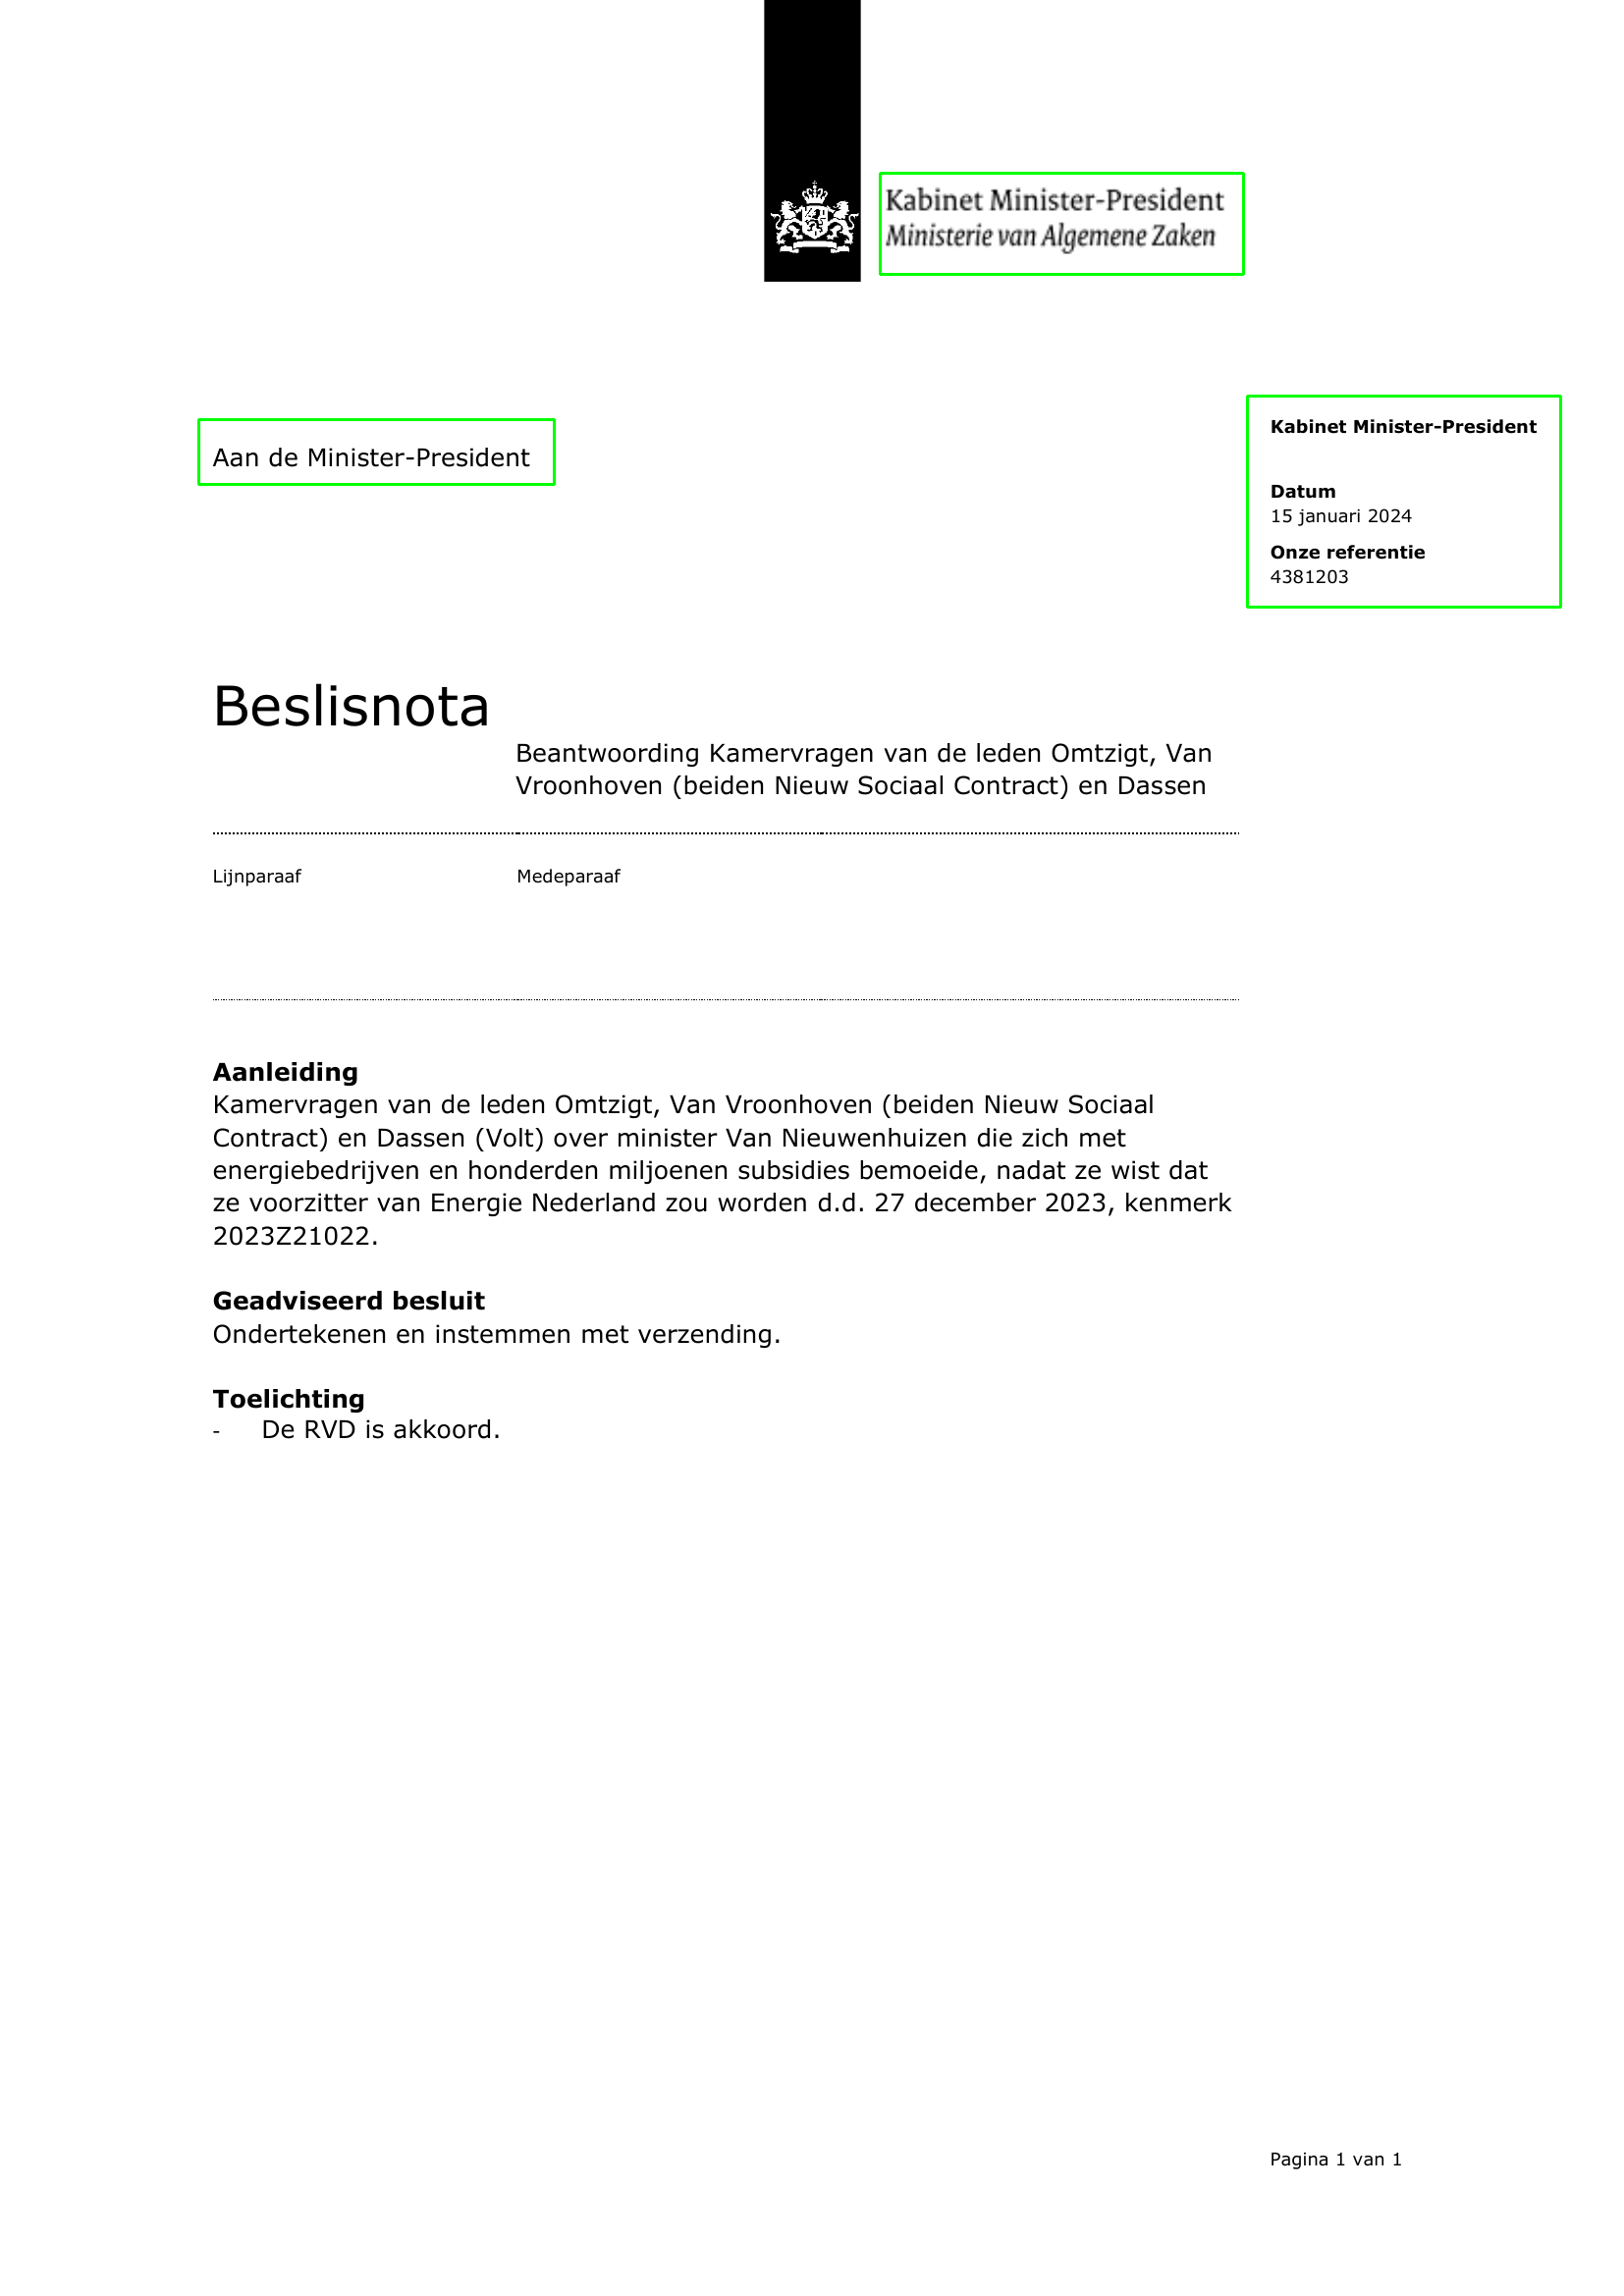

In [16]:
output_boxes = run_onnx_inference(example_images[0])
visualize_boxes(example_images[0], output_boxes)


In [17]:
print(output_boxes)


[[ 896.3237   176.30072 1266.5377   279.06717]
 [1270.0006   403.41052 1589.38     618.9832 ]
 [ 202.79256  427.65622  564.0648   493.19293]]
